Cluster centroids (MBKM_All):
              UnixTime  ET_GazeLeftx  ET_GazeLefty  ET_GazeRightx  \
MBKM_All                                                            
0         1.676898e+09   1035.445312    523.556580      -1.000000   
1         1.677078e+09    886.614990    519.073914     897.913452   
2         1.677236e+09     -1.000000     -1.000000      -1.000000   
3         1.677499e+09     -1.000000     -1.000000     823.585083   

          ET_GazeRighty  ET_PupilLeft  ET_PupilRight  ET_TimeSignal  \
MBKM_All                                                              
0             -1.000000      0.158235      -1.000000  596368.653860   
1            516.208740      0.371054       0.366891  587242.432552   
2             -1.000000     -1.000000      -1.000000  678094.503357   
3            552.612427     -1.000000       0.916096  586114.775089   

          ET_DistanceLeft  ET_DistanceRight  ...  Accelerometer_Z    Gyro_X  \
MBKM_All                                     ... 

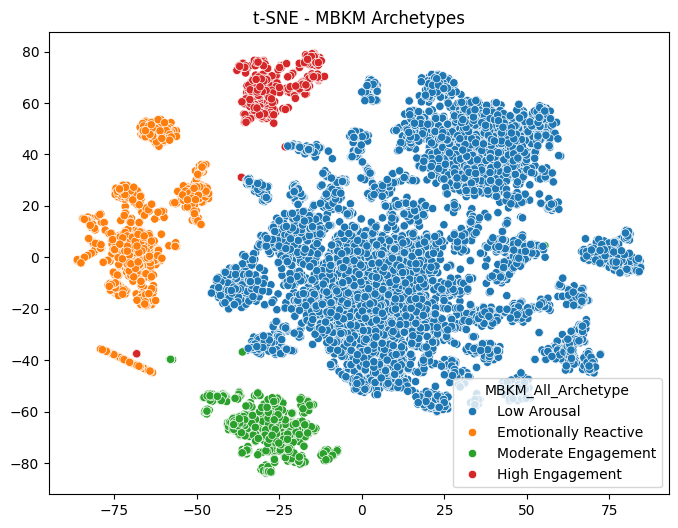

c:\Users\Vishu\miniconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


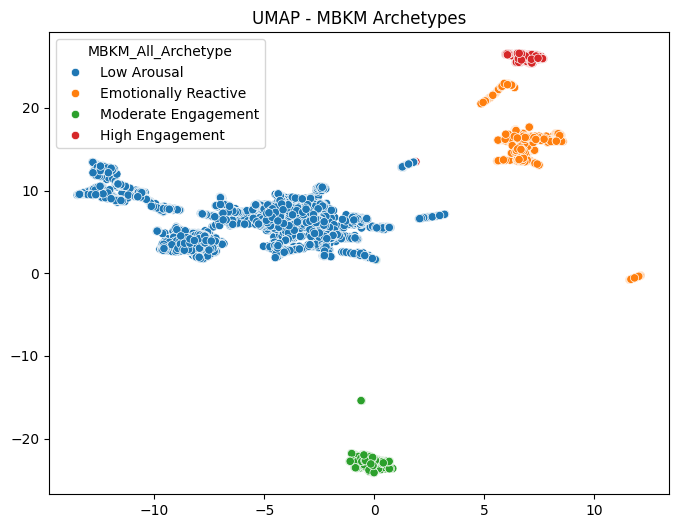

All clustering results, models


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import joblib

# Load dataset
df = pd.read_csv("Final_Dataset.csv")
df = df.drop(columns=['Unnamed: 0', 'TimeStamp'], errors='ignore')
if 'QuestionKey' in df.columns:
    le = LabelEncoder()
    df['QuestionKey_encoded'] = le.fit_transform(df['QuestionKey'])
    df = df.drop('QuestionKey', axis=1)

num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].apply(lambda col: pd.to_numeric(col, downcast='float'))
df[num_cols] = df[num_cols].replace([np.inf, -np.inf], np.nan)
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

sample_size = 10000
df_sample = df.sample(n=sample_size, random_state=42)
X_sample = df_sample[num_cols].values

# Scaling
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_sample)

# PCA for dimensionality reduction
pca = PCA(n_components=20, random_state=42)
X_reduced = pca.fit_transform(X_scaled)

# Autoencoder for nonlinear reduction
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=10):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(input_dim, 50), nn.ReLU(), nn.Linear(50, latent_dim))
        self.decoder = nn.Sequential(nn.Linear(latent_dim, 50), nn.ReLU(), nn.Linear(50, input_dim))
    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
ae = Autoencoder(input_dim=X_scaled.shape[1], latent_dim=10)
optimizer = torch.optim.Adam(ae.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
loader = DataLoader(TensorDataset(X_tensor), batch_size=128, shuffle=True)

for epoch in range(50):
    for batch in loader:
        x_batch = batch[0]
        optimizer.zero_grad()
        x_hat, z = ae(x_batch)
        loss = loss_fn(x_hat, x_batch)
        loss.backward()
        optimizer.step()

with torch.no_grad():
    _, X_latent = ae(X_tensor)
X_latent = X_latent.numpy()

# Feature sets experiments
feature_sets = {"All": num_cols.tolist()}

# Cluster archetypes map
archetype_labels = {
    0: "High Engagement",
    1: "Low Arousal",
    2: "Emotionally Reactive",
    3: "Moderate Engagement"
}

df_results = df_sample.copy()

for name, cols in feature_sets.items():
    X = X_reduced  # Using PCA reduced features
    # MBKM
    mbkm = MiniBatchKMeans(n_clusters=4, random_state=42, batch_size=1000)
    mbkm_labels = mbkm.fit_predict(X)
    df_results[f"MBKM_{name}"] = mbkm_labels
    df_results[f"MBKM_{name}_Archetype"] = df_results[f"MBKM_{name}"].map(archetype_labels)
    # DBSCAN
    db = DBSCAN(eps=0.5, min_samples=5, metric='euclidean', n_jobs=-1)
    db_labels = db.fit_predict(X)
    df_results[f"DBSCAN_{name}"] = db_labels
    # Hierarchical
    linked = linkage(X, method='ward')
    hier_labels = fcluster(linked, 4, criterion='maxclust')
    df_results[f"Hierarchical_{name}"] = hier_labels

# Cluster stability across participants
if 'ParticipantID' in df_results.columns:
    stability = df_results.groupby('ParticipantID')[f"MBKM_All"].nunique()
    print("Cluster stability per participant (MBKM_All):")
    print(stability.value_counts())

# Cluster profiling: mean values
cluster_means = df_results.groupby(f"MBKM_All")[num_cols].mean()
print("Cluster centroids (MBKM_All):")
print(cluster_means)

# t-SNE visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_reduced)
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=df_results[f"MBKM_All_Archetype"], palette="tab10")
plt.title("t-SNE - MBKM Archetypes")
plt.show()

# UMAP visualization
X_umap = umap.UMAP(n_components=2, random_state=42).fit_transform(X_reduced)
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=df_results[f"MBKM_All_Archetype"], palette="tab10")
plt.title("UMAP - MBKM Archetypes")
plt.show()

# Save results
df_results.to_csv("Clustered_Results.csv", index=False)

print("All clustering results, models")
